In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
from sklearn.naive_bayes import GaussianNB
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

In [2]:

# Training data
training_images = []
training_masks = []
train_dir = r"C:\Users\prita\Desktop\AIMIA\AIMIA_Assignment_2\dataset_1\train"

for folder in os.listdir(train_dir):
    subfolder_path = os.path.join(train_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)  # same name in mask folder
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        training_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        training_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")

# Test data
test_images = []
test_masks = []
test_dir = r"C:\Users\prita\Desktop\AIMIA\AIMIA_Assignment_2\dataset_1\test"

for folder in os.listdir(test_dir):
    subfolder_path = os.path.join(test_dir, folder)
    if os.path.isdir(subfolder_path):
        img_folder = os.path.join(subfolder_path, "img")
        mask_folder = os.path.join(subfolder_path, "mask")
        if os.path.isdir(img_folder) and os.path.isdir(mask_folder):
            for file_name in os.listdir(img_folder):
                img_path = os.path.join(img_folder, file_name)
                mask_path = os.path.join(mask_folder, file_name)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    try:
                        img = Image.open(img_path)
                        test_images.append(np.array(img))
                        mask = Image.open(mask_path)
                        test_masks.append(np.array(mask))
                    except Exception as e:
                        print(f"Could not open {img_path} or {mask_path}: {e}")


In [3]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)
test_images = np.array(test_images)
test_masks = np.array(test_masks)
print(f"Shape of training images: {training_images.shape}")
print(f"Shape of training masks: {training_masks.shape}")
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test masks: {test_masks.shape}")

Shape of training images: (1847, 128, 128)
Shape of training masks: (1847, 128, 128)
Shape of test images: (947, 128, 128)
Shape of test masks: (947, 128, 128)


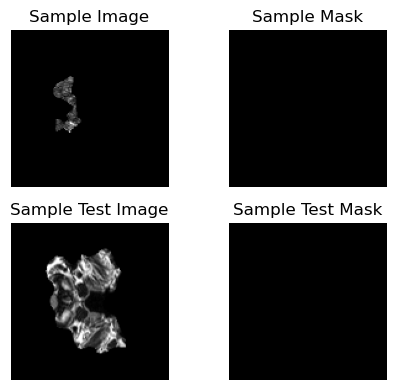

In [4]:
plt.figure(figsize=(6,4))
plt.subplot(2,2,1)
plt.imshow(training_images[0], cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,2)
plt.imshow(training_masks[0], cmap='gray')
plt.title("Sample Mask")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(test_images[0], cmap='gray')
plt.title("Sample Test Image")
plt.axis('off')
plt.tight_layout()
plt.subplot(2,2,4)
plt.imshow(test_masks[0], cmap='gray')
plt.title("Sample Test Mask")
plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def normalize_images(images, method='minmax'):
    normalized = np.empty_like(images, dtype=np.float32)
    for i in range(images.shape[0]):
        img = images[i]
        if method == 'minmax':
            min_val, max_val = np.min(img), np.max(img)
            if max_val != min_val:
                normalized[i] = (img - min_val) / (max_val - min_val)
            else:
                normalized[i] = img  # Avoid division by zero
        elif method == 'zscore':
            mean, std = np.mean(img), np.std(img)
            if std != 0:
                normalized[i] = (img - mean) / std
            else:
                normalized[i] = img  # Avoid division by zero
        else:
            raise ValueError("Method must be 'minmax' or 'zscore'")
    return normalized


In [6]:
train_images_norm = normalize_images(training_images, method='minmax')
test_images_norm = normalize_images(test_images, method='minmax')


In [7]:
X_train = train_images_norm.reshape(-1, 1)  # Pixel intensities
y_train = training_masks.reshape(-1)     # Binary labels (0 or 1)

In [8]:
clf = GaussianNB()
clf.fit(X_train, y_train)


GaussianNB()

In [9]:
X_test = test_images_norm.reshape(-1, 1)
y_pred = clf.predict(X_test)
predicted_masks = y_pred.reshape(test_images.shape)


In [10]:
from sklearn.metrics import f1_score

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    total = np.sum(y_true) + np.sum(y_pred)
    if total == 0:
        return 1.0  
    return 2. * intersection / total

def lesion_wise_accuracy(y_true, y_pred):
    true_lesions = np.unique(y_true)
    pred_lesions = np.unique(y_pred)
    
    true_lesions = true_lesions[true_lesions != 0]
    pred_lesions = pred_lesions[pred_lesions != 0]
    
    true_positive = 0
    false_negative = len(true_lesions)
    false_positive = len(pred_lesions)
    
    for lesion in true_lesions:
        if lesion in pred_lesions:
            true_positive += 1
            false_negative -= 1
            false_positive -= 1
    
    if (true_positive + false_negative) == 0:
        sensitivity = 1.0
    else:
        sensitivity = true_positive / (true_positive + false_negative)
    
    if (true_positive + false_positive) == 0:
        precision = 1.0
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if (precision + sensitivity) == 0:
        f1 = 1.0
    else:
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    
    return f1
# Evaluate on each test sample
dice_scores_nb = []
f1_scores_nb = []
lesion_accuracies_nb = []

for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks[i].flatten()
    dice_scores_nb.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_nb.append(f1)
    lesion_accuracies_nb.append(lesion_wise_accuracy(test_masks[i], predicted_masks[i]))

print("Mean Dice Score for Naive Bayes:", np.mean(dice_scores_nb))
print("Mean F1 Score for Naive Bayes:", np.mean(f1_scores_nb))
print("Mean Lesion-wise Accuracy for Naive Bayes:", np.mean(lesion_accuracies_nb))

Mean Dice Score for Naive Bayes: 0.5015839493136219
Mean F1 Score for Naive Bayes: 0.5015839493136219
Mean Lesion-wise Accuracy for Naive Bayes: 0.5015839493136219


### K-Nearest Neighbour

In [11]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
# knn.fit(X_train, y_train)
# y_pred_knn = knn.predict(X_test)


In [ ]:
dice_scores_knn = []
f1_scores_knn = []
lesion_accuracies_knn = []
predicted_masks_knn = y_pred_knn.reshape(test_images.shape)
for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks_knn[i].flatten()
    dice_scores_knn.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_knn.append(f1)
    lesion_accuracies_knn.append(lesion_wise_accuracy(test_masks[i], predicted_masks_knn[i]))

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
dice_scores_rf = []
f1_scores_rf = []
lesion_accuracies_rf = []
predicted_masks_rf = y_pred_rf.reshape(test_images.shape)
for i in range(test_images.shape[0]):
    true = test_masks[i].flatten()
    pred = predicted_masks_rf[i].flatten()
    dice_scores_rf.append(dice_score(true, pred))
    f1 = f1_score(true, pred, zero_division=1)
    f1_scores_rf.append(f1)
    lesion_accuracies_rf.append(lesion_wise_accuracy(test_masks[i], predicted_masks_rf[i]))

### U-net

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2D(out_channels, out_channels, kernel_size=3,padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        return self.conv_op(x)
    

In [ ]:
class DownSample(nn.Module):
    def  __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

In [ ]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2 , kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels,out_channels)
    
    def forward(self,x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64,out_channels=num_classes, kernel_size=1)
    
    def forward(self,x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b,down_4)
        up_2 = self.up_convolution_2(up_1,down_3)
        up_3 = self.up_convolution_3(up_2,down_2)
        up_4 = self.up_convolution_4(up_3,down_1)

        out = self.out(up_4)
        return out

In [ ]:
#Prepare data for PyTorch
train_images_tensor = torch.tensor(train_images_norm, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
train_masks_tensor = torch.tensor(training_masks, dtype=torch.long)  # Long for classification
test_images_tensor = torch.tensor(test_images_norm, dtype=torch.float32).unsqueeze(1)
test_masks_tensor = torch.tensor(test_masks, dtype=torch.long)
train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
model = UNet(in_channels=1, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [ ]:
# Training loop
def trainer_class(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        validation_loss = 0.0
        for images, masks in train_loader:
            optimizer.zero_grad() # Reset gradients to zero
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(epoch_train_loss)
        model.eval() # Evaluation mode, gradients off
        with torch.no_grad():
            for images, masks in test_loader:
                outputs = model(images)
                loss = criterion(outputs, masks)
                validation_loss += loss.item() * images.size(0)
        epoch_val_loss = validation_loss / len(test_loader.dataset)
        validation_losses.append(epoch_val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return training_losses, validation_losses